In [1]:
##conda install -c -conda-forge fbprophet <-- w konsoli anaconda, potem plotly==3.10.0

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.plotting.register_matplotlib_converters()

from fbprophet import Prophet

from sklearn.metrics import mean_absolute_error as mae

%matplotlib inline

In [44]:
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [3]:
def normal_equation(X,y):
    X_b = np.c_[np.ones((len(X),1)),X]
    theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
    
    return theta_best

In [4]:
def linear_func(X, alfa = None, beta = 0.0):
    if alfa is None:
        mean_value = np.mean(X)
        return [mean_value] * len(X)
    
    X_new = np.linspace(X.min(),X.max(),len(y))
    X_new_b = np.c_[np.ones((len(y),1)), X_new]
        
    return [alfa*x + beta for _, x in X_new_b]

In [5]:
def norm_equation_linear_func(X,y):
    X_new = np.linspace(X.min(),X.max(),len(y))
    X_new_b = np.c_[np.ones((len(y),1)), X_new]
    y_predict = X_new_b.dot(normal_equation(X,y))
    
    return y_predict

In [8]:
path = 'https://github.com/dataworkshop/5dwchallenge_2019/blob/master/challenge5/input/visits.csv?raw=true'

In [11]:
df = pd.read_csv(path, parse_dates=['published'], index_col='published')
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 134137 entries, 2008-01-01 18:19:00 to 2016-10-31 23:56:00
Data columns (total 1 columns):
post_id    134137 non-null int64
dtypes: int64(1)
memory usage: 2.0 MB


In [27]:
df_day = df.resample('1D').count().reset_index()
df_day.columns = ['ds','y']

In [114]:
num_to_pred = 100

train = df_day[:-num_to_pred]
test = df_day[-num_to_pred:]

train_log = train.copy()
train_log['y'] = np.log1p(train_log['y'])

m = Prophet(changepoint_prior_scale=0.2, daily_seasonality=True)
m.fit(train_log);

future = m.make_future_dataframe(periods=num_to_pred, freq='D', include_history=True)
forecast = m.predict(future)
forecast['yhat'] = np.expm1(forecast.yhat)

C:\Users\Adrian\Anaconda3\envs\challange5day\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



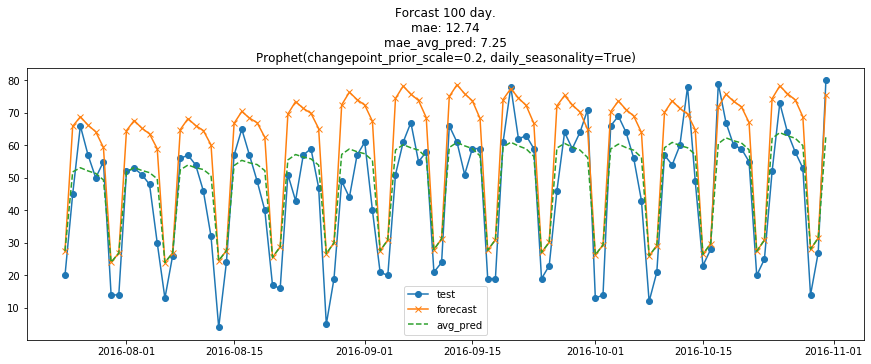

In [117]:
def plot_forecast(test, forecast):
    forecast = forecast[-num_to_pred:]
    regul_param = 1.05
    avg_pred = [np.sqrt(np.power(x,regul_param)*np.power(y,2-regul_param)) if x>y else x for x,y  in zip(forecast.yhat,norm_equation_linear_func(test.index, test.y))]
    score = np.round(mae(test.y, forecast.yhat),2)
    score_avg_pred = np.round(mae(test.y, avg_pred),2)
    plt.figure(figsize=(15,5))
    plt.title('''Forcast {} day.\nmae: {}\nmae_avg_pred: {}\nProphet(changepoint_prior_scale=0.2, daily_seasonality=True)'''.format(num_to_pred,score,score_avg_pred))
    plt.plot(test.ds, test.y, 'o-', label='test')
    plt.plot(test.ds, forecast.yhat, 'x-', label='forecast')
    plt.plot(test.ds, avg_pred, '--', label='avg_pred')
    
    plt.legend();

plot_forecast(test, forecast)

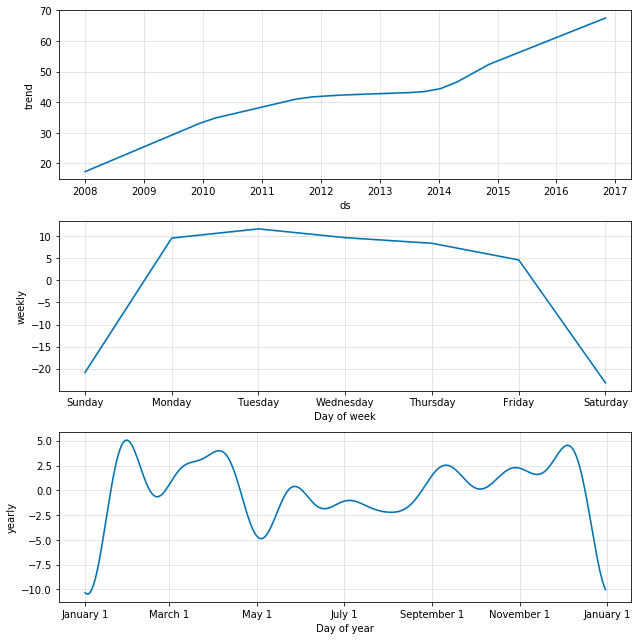

In [56]:
m.plot_components(forecast);

In [45]:
df_cv = cross_validation(m, initial='2500 days', period='10 days', horizon='30 days')

INFO:fbprophet:Making 67 forecasts with cutoffs between 2014-11-11 00:00:00 and 2016-09-01 00:00:00
C:\Users\Adrian\Anaconda3\envs\challange5day\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [49]:
performance_metrics(df_cv).head()

,horizon,mse,rmse,mae,mape,coverage
0,3 days,370.282872,19.242736,16.271774,0.563967,0.432836
1,4 days,334.989938,18.302730,15.700967,0.435427,0.427861
2,5 days,346.539720,18.615577,15.814724,0.476772,0.447761
3,6 days,349.721051,18.700830,15.614186,0.460185,0.467662
4,7 days,377.767308,19.436237,16.167148,0.468468,0.447761


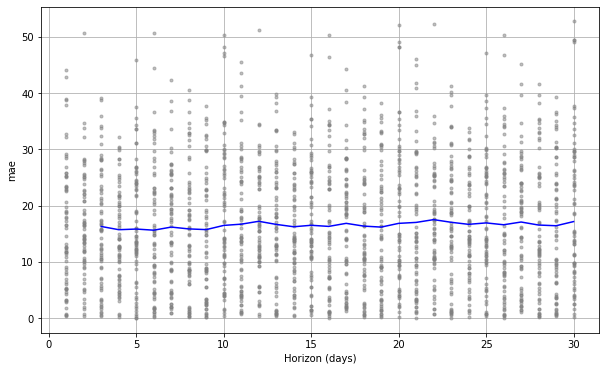

In [52]:
plot_cross_validation_metric(df_cv, 'mae');